# Secondary Modelling : Inception net

This file is part of the Glaucoma Phenotype ML Estimation project.

 Glaucoma Phenotype ML Estimation is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.


The Glaucoma Phenotype ML Estimation project is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with the Glaucoma Phenotype ML Estimation project.  If not, see <http://www.gnu.org/licenses/>.


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Change this as required
import os
os.chdir('/Users/kaiahsteven/Desktop/Work/IOP/glaucoma/glaucoma_ML')

In [5]:
import pickle as pkl
import os
from pathlib import Path
from multiprocessing import Pool, cpu_count
import numpy as np
import pandas as pd
import zipfile
#import imageio
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision import *
from PIL import Image

from fastai.vision.models import *
from fastai.vision.learner import model_meta
from fastai.callbacks import *
import torchvision.models as TorchModels
from glaucoma.helpers.glaucoma_helpers import *


In [3]:
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings(action='ignore')

In [4]:
from fastai.distributed import *

In [15]:
##### PLEASE SET AS REQUIRED########
WORKING_DIR = Path(os.getcwd())
DATA_DIR = WORKING_DIR / 'data'
META_DIR = DATA_DIR / 'metadata'
TRAIN_DIR = DATA_DIR /"train"

In [9]:
# split up unzipped files
unzipped_head, unzipped_tail = split_unzipped(unzipped_files)

In [13]:
meta_df = pickle.load(open(DATA_DIR / "meta_df_v5.pkl",'rb'))

## shedding "risky" files

In [15]:
clean_files = []
for file in meta_df["file_name"].unique():
    df = meta_df[meta_df["file_name"] == file]["grading"].unique()
    var = meta_df[meta_df["file_name"] == file]["grading"]
    if -1 in df:
        continue
    if len(var) > 1 and var.var() > 2:
        continue
    clean_files.append(file)
    

In [13]:
CLEAN_DIR = DATA_DIR / "train_clean"

In [21]:
for rating in range(20):
    os.mkdir(CLEAN_DIR /str(rating/2))

In [20]:
cleaned = meta_df[meta_df["file_name"].isin(clean_files)]

In [ ]:
for rating in range(20):
    f_names = list(cleaned[cleaned['grading'] == rating/2]['file_name'])
    for f in f_names:
        try:
            idx = unzipped_tail.index(f)
        except:
            print(f)
        shutil.copy2(unzipped_files[idx],str(CLEAN_DIR / str(rating/2)))
    print(rating/2," " ,len(f_names))
    

In [177]:
test_imgs = (DATA_DIR /"test").ls()
test_imgs.sort(key=lambda x: x.stem)
data.add_test(test_imgs) 
learn.data = data

## Modelling:

In [15]:
path_img = CLEAN_DIR


In [17]:
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_func(lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2],label_cls=FloatList)
tfms = get_transforms(max_rotate= 10,flip_vert =False, max_lighting = 0.1,max_zoom =1) # or tfms=None if none are needed
size=(800,1040) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

In [18]:
#using smaller image size
src = ImageList.from_folder(str(path_img)).split_by_rand_pct(seed=42).label_from_func(lambda o: (o.parts if isinstance(o, Path) else o.split(os.path.sep))[-2],label_cls=FloatList)
tfms = get_transforms(max_lighting = 0.25) # or tfms=None if none are needed
size=(400,520) # size=(224,224) or (400,224)
data = src.transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH).databunch(num_workers=4).normalize(imagenet_stats)

In [ ]:
data.show_batch(3, figsize=(10,10), hide_axis=False)


In [25]:
import pretrainedmodels


### Inception v4 model

In [29]:
def inceptionv4(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.inceptionv4(pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers[0], *all_layers[1:])

In [30]:
arch_summary(inceptionv4)


(0) BasicConv2d : 3   layers (total: 3)
(1) BasicConv2d : 3   layers (total: 6)
(2) BasicConv2d : 3   layers (total: 9)
(3) Mixed_3a    : 4   layers (total: 13)
(4) Mixed_4a    : 18  layers (total: 31)
(5) Mixed_5a    : 4   layers (total: 35)
(6) Inception_A : 22  layers (total: 57)
(7) Inception_A : 22  layers (total: 79)
(8) Inception_A : 22  layers (total: 101)
(9) Inception_A : 22  layers (total: 123)
(10) Reduction_A : 13  layers (total: 136)
(11) Inception_B : 31  layers (total: 167)
(12) Inception_B : 31  layers (total: 198)
(13) Inception_B : 31  layers (total: 229)
(14) Inception_B : 31  layers (total: 260)
(15) Inception_B : 31  layers (total: 291)
(16) Inception_B : 31  layers (total: 322)
(17) Inception_B : 31  layers (total: 353)
(18) Reduction_B : 19  layers (total: 372)
(19) Inception_C : 31  layers (total: 403)
(20) Inception_C : 31  layers (total: 434)
(21) Inception_C : 31  layers (total: 465)
(22) AvgPool2d   : 1   layers (total: 466)
(23) Linear      : 1   layers (t

In [62]:
learn = cnn_learner(data, inceptionv4, pretrained=True,
                    cut=-2, split_on=lambda m: (m[0][11], m[1]))

In [63]:
class MSELossFlat(nn.MSELoss): 
#“Same as `nn.MSELoss`, but flattens input and target.”
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [64]:
#use both gpus
learn.model = torch.nn.DataParallel(learn.model)

In [66]:
learn.data.batch_size = 20

In [67]:
class L1LossFlat(nn.L1Loss):
#Mean Absolute Error Loss”
    def forward(self, input:Tensor, target:Tensor) -> Rank0Tensor:
        return super().forward(input.view(-1), target.view(-1))

In [68]:
learn.loss = L1LossFlat
learn.loss = MSELossFlat

In [69]:
learn.metrics =[accuracy]

In [70]:
#learn.unfreeze()

In [71]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.10E-06
Min loss divided by 10: 1.45E-02


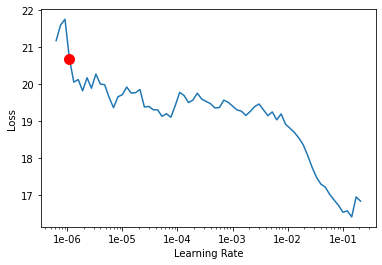

In [72]:
learn.recorder.plot(suggestion = True)

## Training

In [73]:
min_grad_lr = 1e-2

In [ ]:
learn.fit_one_cycle(5,min_grad_lr,callbacks=[SaveModelCallback(learn,name = "inception_clean_best_heat_1")])

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
learn.save("inception_clean_heat_1_e5")

In [ ]:
learn.show_results()

In [38]:
learn.callback_fns =[partial(CSVLogger, append=True)]

In [ ]:
learn.recorder.plot_losses()

## Testing predictions


In [29]:
preds = learn.get_preds()

In [30]:
root_mean_squared_error(preds[0],preds[1])

tensor(2.3862)

In [31]:
mean_absolute_error(*preds)

tensor(1.1477)

In [32]:
exp_rmspe(*preds)

tensor(inf)

In [33]:
mean_squared_error(preds[0],preds[1])

tensor(5.6939)

In [34]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [35]:
r2_score(*preds)

tensor(-0.6718)

### predictions

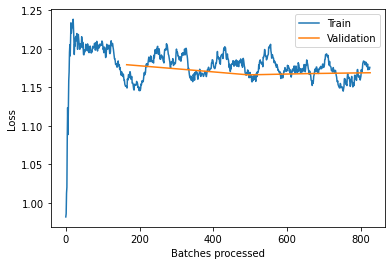

In [85]:
learn_jamie.recorder.plot_losses()

In [121]:
preds =learn_jamie.get_preds()

In [122]:
mean_squared_error(preds[0],preds[1])

tensor(1.1662)

In [123]:
root_mean_squared_error(preds[0],preds[1])

tensor(1.0799)

In [124]:
mean_absolute_error(*preds)

tensor(0.7763)

In [125]:
exp_rmspe(*preds)

tensor(7.4708)

In [111]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [126]:
r2_score(*preds)

tensor(0.6487)

## memory management

In [60]:
torch.cuda.empty_cache()

In [61]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable
